# machine learning?

In [61]:
# import labrary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import matplotlib
from sklearn.model_selection import train_test_split
matplotlib.rcParams['figure.figsize'] = (4, 3)

In [62]:
# get data
data = yf.download('TSLA', start='2021-01-01', end='2023-12-31')
data.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800
2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400
2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400
2023-12-28,263.660004,265.130005,252.710007,253.179993,253.179993,113619900
2023-12-29,255.100006,255.190002,247.429993,248.479996,248.479996,100615300


In [63]:
# 整理数据
data['Prediction'] = data['Close'].shift(-1)
data.dropna(inplace=True)
data.head()
my_data = np.array(data)
x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(my_data[:, :-1], my_data[:, -1], test_size=0.2)
train_set = np.concatenate((x_train_set, y_train_set.reshape(-1, 1)), axis=1)
test_set = np.concatenate((x_test_set, y_test_set.reshape(-1, 1)), axis=1)

In [64]:
# 确定节点值
def value_leaf(dataset):
    return np.mean(dataset[:, -1])

# 确定误差熵
def err_leaf(dataset):
    return np.var(dataset[:, -1]) * np.shape(dataset)[0]

# 划分数据集
def split_dataset(dataset, feature_index, split_value):
    left_dataset = dataset[dataset[:, feature_index] <= split_value]
    right_dataset = dataset[dataset[:, feature_index] > split_value]
    return left_dataset, right_dataset

# 找到最佳分割点
def best_split(dataset, value = value_leaf, err = err_leaf, choose = (10, 4)):
    '''
    choose: 容忍误差熵的范围，容忍孤立个数大小
    '''
    max_S = choose[0]
    max_N = choose[1]
    # 结果只有一个值
    if len(set(dataset[:, -1].T.tolist())) == 1:
        return None, value(dataset)
    m, n = np.shape(dataset)
    S = err(dataset)
    best_S = np.inf
    best_Index = 0
    best_value = 0
    for feature_index in range(n - 1):
        for split_value in set(dataset[:, feature_index]):
            left_dataset, right_dataset = split_dataset(dataset, feature_index, split_value)
            new_S = err(left_dataset) + err(right_dataset)
            if new_S < best_S:
                best_S = new_S
                best_Index = feature_index
                best_value = split_value
    # 误差熵可以容忍
    if (S - best_S) < max_S:
        return None, value(dataset)
    left_dataset, right_dataset = split_dataset(dataset, best_Index, best_value)
    # 划分结果数量太少
    if len(left_dataset) < max_N or len(right_dataset) < max_N:
        return None, value(dataset)
    return best_Index, best_value

# 递归构建决策树
def my_CART(dataset, value = value_leaf, err = err_leaf, choose = (10, 4)):
    feature_index, split_value = best_split(dataset, value, err, choose)
    if feature_index is None:
        return split_value
    left_set, right_set = split_dataset(dataset, feature_index, split_value)
    tree_dict = {}
    tree_dict['feature_index'] = feature_index
    tree_dict['split_value'] = split_value
    tree_dict['left'] = my_CART(left_set, value, err, choose)
    tree_dict['right'] = my_CART(right_set, value, err, choose)
    return tree_dict

# 叶节点判断
def is_tree(obj):
    return (type(obj).__name__ == 'dict')

# 节点均值
def mean_leaf(tree):
    if is_tree(tree['left']):
        tree['left'] = mean_leaf(tree['left'])
    if is_tree(tree['right']):
        tree['right'] = mean_leaf(tree['right'])
    return (tree['left'] + tree['right']) / 2

# 后剪枝
def prune(tree, prune_set):
    if np.shape(prune_set)[0] == 0:
        return mean_leaf(tree)
    if is_tree(tree['left']) or is_tree(tree['right']):
        left_set, right_set = split_dataset(prune_set, tree['feature_index'], tree['split_value'])
    if is_tree(tree['left']):
        tree['left'] = prune(tree['left'], left_set)
    if is_tree(tree['right']):
        tree['right'] = prune(tree['right'], right_set)
    if not is_tree(tree['left']) and not is_tree(tree['right']):
        left_set, right_set = split_dataset(prune_set, tree['feature_index'], tree['split_value'])
        err_before = np.sum(np.square(left_set[:, -1] - tree['left'])) + np.sum(np.square(right_set[:, -1] - tree['right']))
        err_after = np.sum(np.square(prune_set[:, -1] - mean_leaf(tree)))
        if err_after < err_before:
            return mean_leaf(tree)
    return tree

# 预测函数
def predict_model(tree, test_data):
    return float(tree)

# 预测
def predict(tree, test_data, model = predict_model):
    if not is_tree(tree):
        return model(tree, test_data)
    if test_data[tree['feature_index']] > tree['split_value']:
        if is_tree(tree['left']):
            return predict(tree['left'], test_data, model)
        else:
            return model(tree['left'], test_data)
    else:
        if is_tree(tree['right']):
            return predict(tree['right'], test_data, model)
        else:
            return model(tree['right'], test_data)


def creat_forecast(tree, test_data, model = predict_model):
    m = len(test_data)
    y_hat = np.mat(np.zeros((m, 1)))
    for i in range(m):
        y_hat[i, 0] = predict(tree, test_data[i], model)
    return y_hat

In [65]:
my_tree = my_CART(train_set)
my_tree_pro = prune(my_tree, test_set)

d:\app\anaconda\Lib\site-packages\numpy\core\fromnumeric.py:3747: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\app\anaconda\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\app\anaconda\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [67]:
print(my_tree_pro)

{'feature_index': 3, 'split_value': 258.3333435058594, 'left': {'feature_index': 3, 'split_value': 202.77000427246094, 'left': {'feature_index': 3, 'split_value': 157.6699981689453, 'left': {'feature_index': 0, 'split_value': 139.33999633789062, 'left': {'feature_index': 2, 'split_value': 122.26000213623047, 'left': 119.43461491511418, 'right': 128.67999839782715}, 'right': 148.25142778669084}, 'right': {'feature_index': 2, 'split_value': 175.3300018310547, 'left': {'feature_index': 3, 'split_value': 167.97999572753906, 'left': 165.73875045776367, 'right': 175.17142813546317}, 'right': {'feature_index': 3, 'split_value': 194.4199981689453, 'left': {'feature_index': 3, 'split_value': 187.7100067138672, 'left': 185.9610699244908, 'right': 191.7201051712036}, 'right': 198.87366841634113}}}, 'right': {'feature_index': 3, 'split_value': 233.0, 'left': {'feature_index': 3, 'split_value': 215.30999755859375, 'left': {'feature_index': 3, 'split_value': 207.77000427246094, 'left': 203.784029642

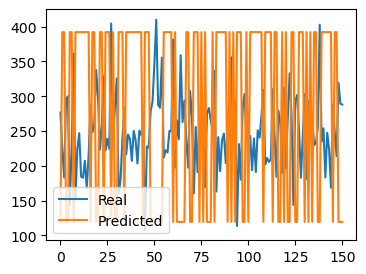

In [66]:
pre = creat_forecast(my_tree_pro, test_set)
real = (test_set[:, -1].reshape(-1, 1))
plt.plot(real, label='Real')
plt.plot(pre, label='Predicted')
plt.legend()
plt.show()